In [811]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from datatools import DataGrapher


%matplotlib inline

In [812]:
#Bring in the data

nba = pd.read_csv('./data/nba_analysis_data.csv')
nba.dropna(inplace = True)

In [813]:
#seperate test from train

nba_train = nba[nba.test == 0]
nba_test = nba[nba.test ==1]  #scott tarlow scotttarlow@gmail.com
#learn a domain

In [814]:
nba_train = nba_train[nba_train.playoff_game == 1]
nba_test = nba_test[nba_test.playoff_game == 1]

In [815]:

X_train = nba_train.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'         ])


#X = nba[features]
y_train = nba_train['cover']

In [816]:
X_test= nba_test.drop(columns = ['cover','home_win_margin', 
                        'date', 'dataset','line_cv', 
                        'home_starter5', 'teams', 'away_team',
                        'away_starter2', 'away_starter3',
                        'away_starter4', 'away_starter5',
                        'ref_1', 'ref_3', 'crew_referees',
                        'away_pace', 'away_spread',
                        'away_line_cv',  'away_cover',
                        'home_payout', 'away_payout', 'over', 'under',
                        'total_score', 'total_diff'       ])

y_test = nba_test.away_cover

In [817]:

X_test.shape

(150, 148)

In [818]:
X_train.shape

(711, 148)

### Interaction Terms

At one point in the modeling process I hoped to get better results by including some interactions in the model.  They did not appear significant and added noise so they were removed, but I left the code in case I wanted to reinsert them later. 

In [819]:

# #create interactions  tested but did not help the model
# poly = PolynomialFeatures(degree = 2, interaction_only= True)
# X_poly = poly.fit_transform(X_train)
# X_poly_test = poly.transform(X_test)
# X_poly = pd.DataFrame(X_poly, 
#                       columns = poly.get_feature_names(X_train.columns))
# X_poly_test = pd.DataFrame(X_poly_test, 
#                            columns = poly.get_feature_names(X_test.columns))


### Scale and Transform the data

I use standard scaler scale the data and then do a principal components analysis to transform the data.  I do not care about inference in this case only prediction and there is a good deal of correlation between variables. So I decided to transform the data to reduce the number and get orthoginal features without losing much information.  I retain 99% of the variance.

In [820]:

#scaling data to use in various other methods
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [821]:
from sklearn.decomposition import PCA

In [822]:
pc = PCA(n_components=70)
X_train_pc = pc.fit_transform(X_train_scaled)
X_test_pc = pc.transform(X_test_scaled)


In [823]:
var_exp = pc.explained_variance_ratio_
print('Explained variance:            ', var_exp)

cum_var_exp = np.cumsum(var_exp)
print('Cumulative explained variance: ', cum_var_exp)

Explained variance:             [0.11834685 0.104883   0.06266254 0.04411775 0.04018636 0.03734666
 0.03476068 0.03171364 0.03139363 0.02753802 0.02744268 0.02399141
 0.02344819 0.01998734 0.01883975 0.01781687 0.01662342 0.01571055
 0.01524122 0.01448081 0.01423059 0.01298795 0.01231318 0.01210623
 0.01140447 0.0102714  0.01001335 0.00975316 0.00923449 0.00848232
 0.00833255 0.00792014 0.00744979 0.00729155 0.00692119 0.00671727
 0.00622452 0.00601655 0.00566995 0.00522665 0.00491279 0.00467794
 0.00460015 0.00420859 0.00404255 0.003902   0.00363442 0.00344473
 0.00337061 0.00319926 0.00308048 0.00296615 0.00273093 0.00265916
 0.00255381 0.00241488 0.00232506 0.00208458 0.00199288 0.00193634
 0.0018755  0.00182403 0.00168129 0.00159446 0.0014911  0.00140418
 0.00136849 0.00133268 0.00128145 0.00116141]
Cumulative explained variance:  [0.11834685 0.22322985 0.28589239 0.33001014 0.3701965  0.40754316
 0.44230384 0.47401748 0.5054111  0.53294913 0.5603918  0.58438321
 0.6078314  0.62781

### Logistic Regression

The first model I tested out was the logistic regression on good thing about the NBA data is that much of the data seemed to be normally distributed and my transformed features are uncorrelated so I thought

In [824]:
lr = LogisticRegressionCV(Cs = [100000],
                         max_iter=1000,
                         penalty = 'l1',
                         tol = .00001,
                         solver ='saga' )


lr.fit(X_train_pc, y_train)
print(lr.score(X_train_pc, y_train))


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6483825597749648


/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [825]:
lr.score(X_test_pc, y_test)

0.5466666666666666

In [826]:
y_hat_lr   = lr.predict(X_train_pc)
y_hat_lrp  = lr.predict_proba(X_train_pc)
y_hat_lrt  = lr.predict(X_test_pc)
y_hat_lrtp = lr.predict_proba(X_test_pc)

In [827]:
print(classification_report(y_train, y_hat_lr))

              precision    recall  f1-score   support

           0       0.63      0.60      0.62       333
           1       0.66      0.69      0.68       378

   micro avg       0.65      0.65      0.65       711
   macro avg       0.65      0.65      0.65       711
weighted avg       0.65      0.65      0.65       711



In [828]:
print(classification_report(y_test, y_hat_lrt))

              precision    recall  f1-score   support

           0       0.53      0.67      0.59        73
           1       0.58      0.43      0.49        77

   micro avg       0.55      0.55      0.55       150
   macro avg       0.55      0.55      0.54       150
weighted avg       0.55      0.55      0.54       150



In [829]:
confusion_matrix( y_train, y_hat_lr)

array([[200, 133],
       [117, 261]])

In [830]:
confusion_matrix( y_test, y_hat_lrt)

array([[49, 24],
       [44, 33]])

### Support Vector Machine

The second model I tested is the Support Vector Machine Model I 

In [831]:
svc = SVC(probability=True)
svc_params = {
    'kernel' : ['linear'  ], 
    'C'      : [.1, .2, .3]
    }

In [832]:
gs = GridSearchCV(svc, 
                  param_grid=svc_params, 
                  scoring='precision', 
                  cv = 5)
gs.fit(X_train_pc, y_train)
print(gs.best_score_)
print(gs.best_params_)

/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.568954386836048
{'C': 0.2, 'kernel': 'linear'}


In [833]:
gs.score(X_test_pc, y_test)

0.5901639344262295

In [834]:
#predict categories and  probabilities for svc model

y_hat_svc   = gs.predict(X_train_pc)
y_hat_svcp  = gs.predict_proba(X_train_pc)
y_hat_svct  = gs.predict(X_test_pc)
y_hat_svctp = gs.predict_proba(X_test_pc)

In [835]:
print(classification_report(y_train, y_hat_svc))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       333
           1       0.68      0.72      0.70       378

   micro avg       0.67      0.67      0.67       711
   macro avg       0.67      0.67      0.67       711
weighted avg       0.67      0.67      0.67       711



In [836]:
print(classification_report(y_test, y_hat_svct))

              precision    recall  f1-score   support

           0       0.54      0.66      0.59        73
           1       0.59      0.47      0.52        77

   micro avg       0.56      0.56      0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.57      0.56      0.56       150



In [837]:
confusion_matrix( y_train, y_hat_svc)

array([[206, 127],
       [106, 272]])

In [838]:
confusion_matrix( y_test, y_hat_svct)

array([[48, 25],
       [41, 36]])

### Neural Network

I also wanted to try fitting a neural network.  I do not care about the inference implications, but I found that the neural network had to much variance depending on starting weights so I decided not to use it in predictions.  

In [839]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

In [840]:
model = Sequential()
model.add(Dense(70, 
                activation = 'relu',
                input_dim = X_train_pc.shape[1],
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.8))

#model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) #output layer 

In [841]:
model.compile(loss = 'binary_crossentropy', optimizer='adam',
              metrics = ['accuracy'])
model.fit(X_train_pc, 
          y_train, epochs =50, 
          batch_size= 128, 
          validation_data=(X_test_pc, y_test))

Train on 711 samples, validate on 150 samples
Epoch 1/50
711/711 [==============================] - 1s 995us/step - loss: 1.9300 - acc: 0.5556 - val_loss: 1.4078 - val_acc: 0.5467
Epoch 2/50
711/711 [==============================] - 0s 19us/step - loss: 1.9645 - acc: 0.5077 - val_loss: 1.3780 - val_acc: 0.5400
Epoch 3/50
711/711 [==============================] - 0s 16us/step - loss: 1.8519 - acc: 0.5007 - val_loss: 1.3507 - val_acc: 0.5267
Epoch 4/50
711/711 [==============================] - 0s 16us/step - loss: 1.8580 - acc: 0.4951 - val_loss: 1.3264 - val_acc: 0.5533
Epoch 5/50
711/711 [==============================] - 0s 17us/step - loss: 1.7177 - acc: 0.5260 - val_loss: 1.3018 - val_acc: 0.5667
Epoch 6/50
711/711 [==============================] - 0s 17us/step - loss: 1.7582 - acc: 0.4852 - val_loss: 1.2793 - val_acc: 0.5600
Epoch 7/50
711/711 [==============================] - 0s 16us/step - loss: 1.6866 - acc: 0.5246 - val_loss: 1.2577 - val_acc: 0.5600
Epoch 8/50
711/711 [==

In [842]:
#returns a probability

y_hat_nnp = model.predict(X_train_pc)
y_hat_nntp = model.predict(X_test_pc)


In [843]:
rf = RandomForestClassifier()
rf_params = {'n_estimators'      : [70],
             'max_depth'         : [50],
             'min_samples_split' : [120],
             'min_samples_leaf'  : [10] }

gs1 = GridSearchCV(rf, 
                  param_grid=rf_params,
                  scoring='precision',
                 cv =5)
gs1.fit(X_train_pc, y_train)
print(gs1.best_score_)
print(gs1.best_params_)



0.5543848652566185
{'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 120, 'n_estimators': 70}


In [844]:
gs1.score(X_test_pc, y_test)

0.5816326530612245

In [845]:
y_hat_rf   = gs1.predict(X_train_pc)
y_hat_rfp  = gs1.predict_proba(X_train_pc)
y_hat_rft  = gs1.predict(X_test_pc)
y_hat_rftp = gs1.predict_proba(X_test_pc)

In [846]:
print(classification_report(y_train, y_hat_rf))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       333
           1       0.76      0.96      0.85       378

   micro avg       0.82      0.82      0.82       711
   macro avg       0.85      0.81      0.81       711
weighted avg       0.84      0.82      0.81       711



In [847]:
print(classification_report(y_test, y_hat_rft))

              precision    recall  f1-score   support

           0       0.62      0.44      0.51        73
           1       0.58      0.74      0.65        77

   micro avg       0.59      0.59      0.59       150
   macro avg       0.60      0.59      0.58       150
weighted avg       0.60      0.59      0.58       150



In [848]:
confusion_matrix( y_train, y_hat_rf)

array([[216, 117],
       [ 14, 364]])

In [849]:
confusion_matrix( y_test, y_hat_rft)

array([[32, 41],
       [20, 57]])

In [866]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves 
#Random Forest
nba_train.loc[:, 'actual_y'] = y_train
nba_train.loc[:, 'predicted_label_rf'] = y_hat_rf
nba_train.loc[:, 'predicted_proba_rfp'] = y_hat_rfp[:, 1]

#SVC

nba_train.loc[:, 'predicted_label_svc'] = y_hat_svc
nba_train.loc[:, 'predicted_proba_svcp'] = y_hat_svcp[:, 1]

#Logistic
nba_train.loc[:, 'predicted_label_lr'] = y_hat_lr
nba_train.loc[:, 'predicted_proba_lrp'] = y_hat_lrp[:, 1]



In [892]:
#Random Forest
nba_test.loc[:, 'actual_y'] = y_test
nba_test.loc[:, 'predicted_label_rf'] = y_hat_rft
nba_test.loc[:, 'predicted_proba_rfp'] = y_hat_rftp[:, 1]

#SVC

nba_test.loc[:, 'predicted_label_svc'] = y_hat_svct
nba_test.loc[:, 'predicted_proba_svcp'] = y_hat_svctp[:,1]

#Logistic
nba_test.loc[:, 'predicted_label_lr'] = y_hat_lrt
nba_test.loc[:, 'predicted_proba_lrp'] = y_hat_lrtp[:, 1]



#Neural Network
nba_test.loc[:, 'predicted_proba_nnp'] = y_hat_nntp
nba_test.loc[:, 'predicted_label_nn'] = nba_test.predicted_proba_nnp.map(
                lambda x: 0 if x<=.5 else 1)





In [893]:
print(nba_test.groupby(['predicted_label_svc'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_svc'])['home_payout'].sum())

predicted_label_svc
0   -9.731
1    8.724
Name: away_payout, dtype: float64
predicted_label_svc
0     1.723
1   -14.184
Name: home_payout, dtype: float64


In [894]:
print(nba_test.groupby(['predicted_label_lr'])['away_payout'].sum())
print(nba_test.groupby(['predicted_label_lr'])['home_payout'].sum())

predicted_label_lr
0   -8.004
1    6.997
Name: away_payout, dtype: float64
predicted_label_lr
0    -0.368
1   -12.093
Name: home_payout, dtype: float64


In [887]:
from sklearn.metrics import roc_curve, auc

In [888]:
fpr, tpr, _ = roc_curve(y_test, nba_test['predicted_proba_lrp'])
roc_auc = auc(fpr, tpr)

In [889]:
fpr1, tpr1, _ = roc_curve(y_test, nba_test['predicted_proba_svcp'])
roc_auc1 = auc(fpr1, tpr1)

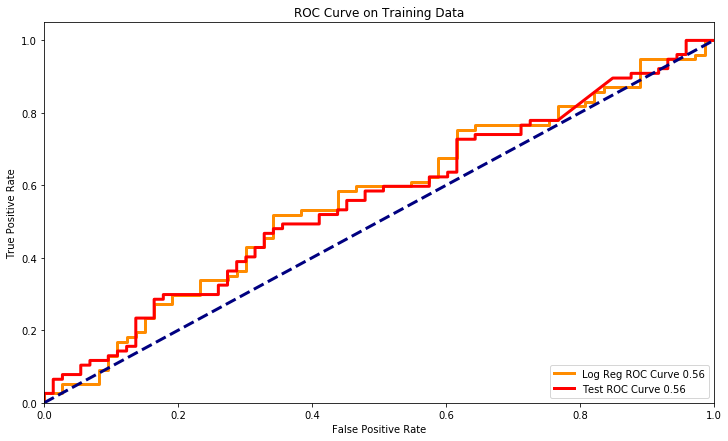

In [890]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", 
         label = "Log Reg ROC Curve %.2f" % roc_auc)
plt.plot(fpr1, tpr1, lw = line_width, color="red", 
         label = "Test ROC Curve %.2f" % roc_auc1)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc="lower right")
plt.show()

In [891]:
for prob in range(40, 60, 1):
    proba = prob/100
    
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
        lambda p: 1 if p > proba else 0)
    
    nba_test.loc[:, 'predicted_label_svc']= nba_test['predicted_proba_svcp'].map(
        lambda p: 1 if p > proba else 0)
    

    
    print('Test Logistic Regression :' + str(proba))

    print ("Return of Away Games: ", nba_test.groupby(
        "predicted_label_lr").away_payout.sum())
    print ("Return of Home Games: ", nba_test.groupby(
        "predicted_label_lr").home_payout.sum())
    
    print (" ")
   
    print('Test SVC :' + str(proba))    
    print ("Return of Away Games SVC: ", nba_test.groupby(
        "predicted_label_svc").away_payout.sum())
    print ("Return of Home Games SVC: ", nba_test.groupby(
        "predicted_label_svc").home_payout.sum())
    print("")
    
  

Test Logistic Regression :0.4
Return of Away Games:  predicted_label_lr
0   -3.730
1    2.723
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0    -1.821
1   -10.640
Name: home_payout, dtype: float64
 
Test SVC :0.4
Return of Away Games SVC:  predicted_label_svc
1   -1.007
Name: away_payout, dtype: float64
Return of Home Games SVC:  predicted_label_svc
1   -12.461
Name: home_payout, dtype: float64

Test Logistic Regression :0.41
Return of Away Games:  predicted_label_lr
0   -5.821
1    4.814
Name: away_payout, dtype: float64
Return of Home Games:  predicted_label_lr
0    -0.094
1   -12.367
Name: home_payout, dtype: float64
 
Test SVC :0.41
Return of Away Games SVC:  predicted_label_svc
1   -1.007
Name: away_payout, dtype: float64
Return of Home Games SVC:  predicted_label_svc
1   -12.461
Name: home_payout, dtype: float64

Test Logistic Regression :0.42
Return of Away Games:  predicted_label_lr
0   -6.821
1    5.814
Name: away_payout, dtype: float64
Return of

In [876]:
    nba_test.loc[:, 'predicted_label_lr']= nba_test['predicted_proba_lrp'].map(
    lambda p: 1 if p > .48 else 0)
    
    nba_test.loc[:, 'predicted_label_svc']= nba_test.predicted_proba_svcp.map(
    lambda p: 1 if p > .50 else 0)

In [897]:
#Combined 
nba_test['vote'] = nba_test.predicted_label_svc + nba_test.predicted_label_lr
              

In [898]:
nba_test.vote.value_counts(normalize = True)

0    0.573333
2    0.360000
1    0.066667
Name: vote, dtype: float64

In [899]:
nba_test.groupby(['vote'])['away_payout'].sum()

vote
0   -6.731
1   -4.273
2    9.997
Name: away_payout, dtype: float64

In [900]:
nba_test.groupby(['vote'])['home_payout'].sum()

vote
0    -1.004
1     3.363
2   -14.820
Name: home_payout, dtype: float64

In [901]:
nba_test.predicted_label_svc
nba_test.groupby(['predicted_label_svc'])['predicted_proba_svcp'].mean()
    

predicted_label_svc
0    0.506014
1    0.545067
Name: predicted_proba_svcp, dtype: float64

In [895]:
y_hat_svctp

array([[0.5       , 0.5       ],
       [0.48040954, 0.51959046],
       [0.44856839, 0.55143161],
       [0.45263482, 0.54736518],
       [0.5       , 0.5       ],
       [0.48033721, 0.51966279],
       [0.54310277, 0.45689723],
       [0.51623095, 0.48376905],
       [0.52803415, 0.47196585],
       [0.51681794, 0.48318206],
       [0.5       , 0.5       ],
       [0.46619345, 0.53380655],
       [0.5       , 0.5       ],
       [0.49436465, 0.50563535],
       [0.42997078, 0.57002922],
       [0.43372491, 0.56627509],
       [0.45472612, 0.54527388],
       [0.44087805, 0.55912195],
       [0.45359186, 0.54640814],
       [0.46974645, 0.53025355],
       [0.48509434, 0.51490566],
       [0.42866194, 0.57133806],
       [0.45939148, 0.54060852],
       [0.48947643, 0.51052357],
       [0.48324261, 0.51675739],
       [0.48813584, 0.51186416],
       [0.48683349, 0.51316651],
       [0.48208651, 0.51791349],
       [0.45927496, 0.54072504],
       [0.47703639, 0.52296361],
       [0.

In [896]:
nba_test.predicted_proba_svcp

10206    0.500000
10207    0.519590
10208    0.551432
10242    0.547365
10243    0.500000
10244    0.519663
10245    0.456897
10246    0.483769
10247    0.471966
10248    0.483182
10249    0.500000
10315    0.533807
10316    0.500000
10317    0.505635
10352    0.570029
10353    0.566275
10354    0.545274
10355    0.559122
10356    0.546408
10357    0.530254
10358    0.514906
10359    0.571338
10360    0.540609
10361    0.510524
10493    0.516757
10494    0.511864
10495    0.513167
10496    0.517913
10497    0.540725
10498    0.522964
           ...   
11723    0.524890
11757    0.548502
11758    0.518361
11759    0.527249
11791    0.500000
11792    0.471970
11793    0.476109
11794    0.474575
11795    0.471009
11894    0.478401
11895    0.500000
11896    0.518507
11897    0.488557
11898    0.469587
11966    0.540067
11967    0.549269
12032    0.541066
12033    0.530337
12034    0.541599
12068    0.493550
12069    0.500000
12070    0.500000
12071    0.530660
12072    0.516665
12106    0